<a href="https://colab.research.google.com/github/guyez/NLP/blob/main/DistilBertQA_eval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Dependencies


Let's install the [transformers](https://github.com/huggingface/transformers) and [datasets](https://github.com/huggingface/datasets) packages from Hugging Face which will give us a pytorch interface for working with transformers. (This library contains interfaces for other pretrained language models like OpenAI's GPT and GPT-2).

At the moment, the Hugging Face library seems to be the most widely accepted and powerful pytorch interface for working with transformers. In addition to supporting a variety of different pre-trained transformer models, the library also includes pre-built modifications of these models suited to your specific task.

The library also includes task-specific classes for token classification, question answering, next sentence prediciton, etc.

Datasets is a lightweight library providing simple, fast and reproducible data pre-processing for the public datasets as well as your own local datasets in CSV/JSON/text. With simple commandes like `tokenized_dataset = dataset.map(tokenize_exemple)` efficiently prepare the dataset for inspection and ML model evaluation and training.


In [47]:
!pip install transformers
!pip install datasets

In [48]:
import numpy as np
import pandas as pd

import torch

import json
import sys
import time
import datetime
import random
import collections
from pathlib import Path

import transformers
import datasets
from datasets import load_dataset

from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [49]:
torch.__version__

'1.8.0+cu101'

In [50]:
transformers.__version__

'4.3.3'

In [51]:
datasets.__version__

'1.4.1'

# Reproducibility






In [52]:
def fix_random(seed: int) -> None:
    """Fix all the possible sources of randomness.

    Args:
        seed: the seed to use.
    """

    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

In [53]:
fix_random(seed=42)

# Runtime Settings

Here we set the `device`, which is used to place tensors on our GPU, if we have one. If no GPU is available, you should change the Runtime settings. 

In [54]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [55]:
!nvidia-smi

Thu Mar 11 15:01:30 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   74C    P0    78W / 149W |    898MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#Load

In [57]:
# Folder on your Google Drive where all the checkpoints will be saved and where the dataset files are stored and loaded from
FOLDER_NAME = "NLPproject" # @param {type: "string"}
JSON_TEST_FILE = "test_set.json" # @param {type: "string"}
data_path = "drive/My Drive/" + FOLDER_NAME +"/"  # Full path to Drive folder
file_path = data_path + JSON_TEST_FILE
checkpoint_path = data_path

In [56]:
class LoadData():
    def __init__(self,
                 path_to_json_file: str,
                 checkpoint_path: str,
                 test_file: str = 'test.json') -> None:
        """Load the data by flattening the json file and saving it.

          Args:
              path_to_json_file: path to the json file.
              checkpoint_path: path where to save the json file.
              test_file: name of the test json file that will be created.
        """

        self.path_to_json_file = path_to_json_file
        self.checkpoint_path = checkpoint_path

        self.test_file = test_file

        self.data = self.load_data()

    def load_data(self):
        with open(self.path_to_json_file, 'r') as f:
            test_data = json.load(f)
        print(f'Flattening SQUAD {test_data["version"]}')
        test_data_flat, errors = self.load_squad_data(test_data)
        print(f'\nErroneous Datapoints: {errors}')

        with open(Path(self.checkpoint_path) / Path(self.test_file), 'w') as file:
            test_data = {'data':test_data_flat}
            file.write(json.dumps(test_data))
            file.close()


    def load_squad_data(self, data):

        errors = 0
        flattened_data_test = []

        for i, article in enumerate(data["data"]):
            title = article.get("title", "").strip()
            for paragraph in article["paragraphs"]:
                context = paragraph["context"].strip()
                for qa in paragraph["qas"]:
                    question = qa["question"].strip()
                    id_ = qa["id"]

                    answer_starts = [answer["answer_start"] for answer in qa["answers"]]
                    answers = [answer["text"].strip() for answer in qa["answers"]]

                    # Features currently used are "context", "question", and "answers".
                    # Others are extracted here for the ease of future expansions.
                    flattened_data_test.append({"title": title,
                                                "context": context,
                                                "question": question,
                                                "id": id_,
                                                "answers": {
                                                    "answer_start": answer_starts,
                                                    "text": answers}
                                                })

        return flattened_data_test, errors

In [58]:
_ = LoadData(file_path, checkpoint_path)

Flattening SQUAD 1.1

Erroneous Datapoints: 0


In [59]:
from datasets import load_dataset
test_data = load_dataset('json', data_files=data_path+"test.json", field='data')

Using custom data configuration default-ea6d574ff49da606


Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/default-ea6d574ff49da606/0.0.0/dc7ee63ec8b554c48ecc5a8a6fbe27af8071408c244e4347cf9222d6206d83a2. Subsequent calls will reuse this data.


In [60]:
def get_text(answer: list) -> str:
    """Extract only the text from the answers.text column 

    Args:
        answer: the answer.
    """
    return answer[0]

def get_json_data(json_path: str) -> dict:
    """Get the json data in form of a dictionary

    Args:
        json_path: path to the json file.
    """
    # Opening JSON file 
    f = open(json_path) 
    # returns JSON object as a dictionary 
    json_data = json.load(f) 
    # Closing file 
    f.close() 
    return json_data

test_dataframe = pd.json_normalize(get_json_data(data_path+"test.json"), record_path='data')
test_dataframe["answers.text"] = test_dataframe["answers.text"].apply(get_text)

test_dataframe

,title,context,question,id,answers.answer_start,answers.text
0,Super_Bowl_50,Super Bowl 50 was an American football game to...,Which NFL team represented the AFC at Super Bo...,56be4db0acb8001400a502ec,"[177, 177, 177]",Denver Broncos
1,Super_Bowl_50,Super Bowl 50 was an American football game to...,Which NFL team represented the NFC at Super Bo...,56be4db0acb8001400a502ed,"[249, 249, 249]",Carolina Panthers
2,Super_Bowl_50,Super Bowl 50 was an American football game to...,Where did Super Bowl 50 take place?,56be4db0acb8001400a502ee,"[403, 355, 355]","Santa Clara, California"
3,Super_Bowl_50,Super Bowl 50 was an American football game to...,Which NFL team won Super Bowl 50?,56be4db0acb8001400a502ef,"[177, 177, 177]",Denver Broncos
4,Super_Bowl_50,Super Bowl 50 was an American football game to...,What color was used to emphasize the 50th anni...,56be4db0acb8001400a502f0,"[488, 488, 521]",gold
...,...,...,...,...,...,...
10565,Force,"The pound-force has a metric counterpart, less...",What is the metric term less used than the New...,5737aafd1c456719005744fb,"[82, 4, 82, 82, 78]",kilogram-force
10566,Force,"The pound-force has a metric counterpart, less...",What is the kilogram-force sometimes reffered ...,5737aafd1c456719005744fc,"[114, 114, 114, 114, 114]",kilopond
10567,Force,"The pound-force has a metric counterpart, less...",What is a very seldom used unit of mass in the...,5737aafd1c456719005744fd,"[274, 267, 267, 267, 263]",slug
10568,Force,"The pound-force has a metric counterpart, less...",What seldom used term of a unit of force equal...,5737aafd1c456719005744fe,"[712, 712, 712, 712, 712]",kip


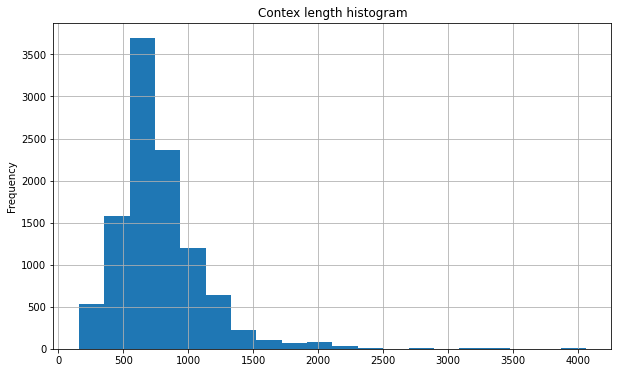

In [61]:
figsize = (10,6)
test_dataframe['context'].apply(len).plot.hist(title="Contex length histogram", bins=20, figsize=figsize, grid=True)

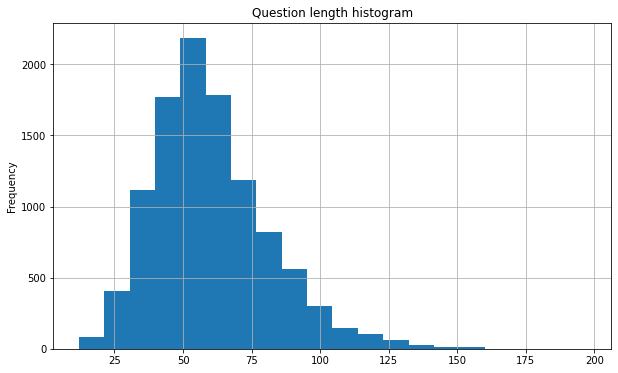

In [62]:
test_dataframe['question'].apply(len).plot.hist(title="Question length histogram", bins=20, figsize=figsize, grid=True)

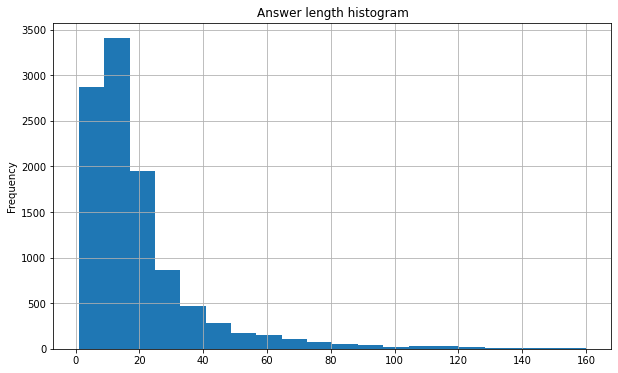

In [63]:
test_dataframe['answers.text'].apply(len).plot.hist(title="Answer length histogram", bins=20, figsize=figsize, grid=True)

In [64]:
#@title Show Samples { run: "auto", display-mode: "form" }

def print_squad_sample(df: pd.core.frame.DataFrame, line_length: int=20, separator_length: int=120) -> None:
  sample = df.iloc[random.randint(0,df.shape[0])]
  title = sample.title.replace('_', ' ')
  print('TITLE: ')
  print(title)
  print('='*separator_length)
  context = sample.context.split()
  print('CONTEXT: ')
  lines = [' '.join(context[idx:idx+line_length]) for idx in range(0, len(context), line_length)]
  for l in lines:
      print(l)
  print('='*separator_length)
  questions = df[df.context.values==sample.context]
  max_len = len(max(questions.question, key=len)) + 5
  print("{: <{max_len}} {: <{max_len}}".format('QUESTION:','ANSWER:', max_len=max_len))
  for idx, row in questions.iterrows():
    question = row.question
    answer = row['answers.text']
    print("{: <{max_len}} {: <{max_len}}".format(question,answer, max_len=max_len))
    
print_squad_sample(test_dataframe)

TITLE: 
Force
CONTEXT: 
Newton came to realize that the effects of gravity might be observed in different ways at larger distances. In particular,
Newton determined that the acceleration of the Moon around the Earth could be ascribed to the same force of gravity
if the acceleration due to gravity decreased as an inverse square law. Further, Newton realized that the acceleration due to
gravity is proportional to the mass of the attracting body. Combining these ideas gives a formula that relates the mass
() and the radius () of the Earth to the gravitational acceleration:
QUESTION:                                                                                                                     ANSWER:                                                                                                                      
How might gravity effects be observed differently according to Newton?                                                        at larger distances.                         

#Preprocessing the data

Before we can feed those texts to our model, we need to preprocess them. This is done by a 🤗 Transformers Tokenizer which will (as the name indicates) tokenize the inputs (including converting the tokens to their corresponding IDs in the pretrained vocabulary) and put it in a format the model expects, as well as generate the other inputs that model requires.

To do all of this, we instantiate our tokenizer with the AutoTokenizer.from_pretrained method, which will ensure:

- we get a tokenizer that corresponds to the model architecture we want to use,
- we download the vocabulary used when pretraining this specific checkpoint.

That vocabulary will be cached, so it's not downloaded again the next time we run the cell.

As model_checkpoint we use the best performing version of our DistilBertForQuestionAnswering which we have uploaded on the HuggingFace Hub.

In [65]:
from transformers import AutoTokenizer

model_checkpoint = "nlpunibo/distilbert_config3"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [66]:
max_length = 384 # The maximum length of a feature (question and context)
doc_stride = 128 # The authorized overlap between two part of the context when splitting it is needed.
pad_on_right = True # Our model expects padding on the right

# Evaluation

We can download the pretrained model. We use our modified version of the `DistilBertForQuestionAnswering` class. Like with the tokenizer, the `from_pretrained` method will download and cache the model for us.

In [67]:
# DistilBert

import math

from transformers.modeling_outputs import QuestionAnsweringModelOutput
from transformers import DistilBertPreTrainedModel
from transformers import DistilBertModel

from torch import nn
from torch.nn import CrossEntropyLoss


def gelu(x):
    """
    Original Implementation of the GELU activation function in Google BERT repo when initially created. For
    information: OpenAI GPT's GELU is slightly different (and gives slightly different results): 0.5 * x * (1 +
    torch.tanh(math.sqrt(2 / math.pi) * (x + 0.044715 * torch.pow(x, 3)))) This is now written in C in
    torch.nn.functional Also see the Gaussian Error Linear Units paper: https://arxiv.org/abs/1606.08415
    """
    return x * 0.5 * (1.0 + torch.erf(x / math.sqrt(2.0)))


def gelu_new(x):
    """
    Implementation of the GELU activation function currently in Google BERT repo (identical to OpenAI GPT). Also see
    the Gaussian Error Linear Units paper: https://arxiv.org/abs/1606.08415
    """
    return 0.5 * x * (1.0 + torch.tanh(math.sqrt(2.0 / math.pi) * (x + 0.044715 * torch.pow(x, 3.0))))


class DistilBertForQuestionAnswering(DistilBertPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)

        self.distilbert = DistilBertModel(config)

        self.qa_outputs_0 = nn.Linear(config.dim, 512)
        self.qa_outputs_1 = nn.Linear(512, 32)
        self.qa_outputs = nn.Linear(32, config.num_labels)
        
        assert config.num_labels == 2
        self.dropout = nn.Dropout(config.qa_dropout)

        self.LayerNorm = nn.LayerNorm(normalized_shape = [384,2])

        self.init_weights()

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        head_mask=None,
        inputs_embeds=None,
        start_positions=None,
        end_positions=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):
        r"""
        start_positions (:obj:`torch.LongTensor` of shape :obj:`(batch_size,)`, `optional`):
            Labels for position (index) of the start of the labelled span for computing the token classification loss.
            Positions are clamped to the length of the sequence (:obj:`sequence_length`). Position outside of the
            sequence are not taken into account for computing the loss.
        end_positions (:obj:`torch.LongTensor` of shape :obj:`(batch_size,)`, `optional`):
            Labels for position (index) of the end of the labelled span for computing the token classification loss.
            Positions are clamped to the length of the sequence (:obj:`sequence_length`). Position outside of the
            sequence are not taken into account for computing the loss.
        """
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict


        distilbert_output = self.distilbert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

 
        hidden_states = distilbert_output[0]  # (bs, max_query_len, dim)
        hidden_states = self.dropout(hidden_states)  # (bs, max_query_len, dim)

        logits = gelu_new(self.qa_outputs_0(hidden_states))  # (bs, max_query_len, 2)
        logits = gelu_new(self.qa_outputs_1(logits))
        #logits = self.LayerNorm_0(logits)
      
        logits = self.qa_outputs(logits)
        logits = self.LayerNorm(logits)
       
        start_logits, end_logits = logits.split(1, dim=-1)

        start_logits = start_logits.squeeze(-1)  # (bs, max_query_len)
        end_logits = end_logits.squeeze(-1)  # (bs, max_query_len)


        total_loss = None
        if start_positions is not None and end_positions is not None:

            # sometimes the start/end positions are outside our model inputs, we ignore these terms
            ignored_index = start_logits.size(1)
            start_positions.clamp_(0, ignored_index)
            end_positions.clamp_(0, ignored_index)

            loss_fct = nn.CrossEntropyLoss(ignore_index=ignored_index)
            start_loss = loss_fct(start_logits, start_positions)
            end_loss = loss_fct(end_logits, end_positions)
            total_loss = (start_loss + end_loss) / 2

        if not return_dict:
          output = (start_logits, end_logits) + distilbert_output[1:]
          return ((total_loss,) + output) if total_loss is not None else output
 
        return QuestionAnsweringModelOutput(
            loss=total_loss,
            start_logits=start_logits,
            end_logits=end_logits,
            hidden_states=distilbert_output.hidden_states,
            attentions=distilbert_output.attentions
        )

In [68]:
from transformers import TrainingArguments, Trainer

model = DistilBertForQuestionAnswering.from_pretrained(model_checkpoint)

# Tell pytorch to run this model on the GPU.
if torch.cuda.is_available():
  model.cuda()

Evaluating our model will require some work, as we will need to map the predictions of our model back to parts of the context. The model itself predicts logits for the start and end position of our answers. The output of the model is a dict-like object that contains the loss (since we provided labels), the start and end logits.

We have one logit for each feature and each token. The most obvious thing to predict an answer for each feature is to take the index for the maximum of the start logits as a start position and the index of the maximum of the end logits as an end position.

This will work great in a lot of cases, but what if this prediction gives us something impossible: the start position could be greater than the end position, or point to a span of text in the question instead of the answer. In that case, we might want to look at the second best prediction to see if it gives a possible answer and select that instead.

However, picking the second best answer is not as easy as picking the best one: is it the second best index in the start logits with the best index in the end logits? Or the best index in the start logits with the second best index in the end logits? And if that second best answer is not possible either, it gets even trickier for the third best answer.

To classify our answers, we will use the score obtained by adding the start and end logits. We won't try to order all the possible answers and limit ourselves to with a hyper-parameter we call `n_best_size`. We'll pick the best indices in the start and end logits and gather all the answers this predicts. After checking if each one is valid, we will sort them by their score and keep the best one.

We also eliminate very long answers from our considerations (with an hyper-parameter we can tune).

Since one example can give several features, we will need to gather together all the answers in all the features generated by a given example, then pick the best one. We need to build a map from example index to its corresponding features indices.


 All combined together, this gives us this `post-processing` function:

In [69]:
import collections
from tqdm import tqdm, tqdm_notebook

def postprocess_qa_predictions(examples: datasets.arrow_dataset.Dataset,
                               features: datasets.arrow_dataset.Dataset,
                               raw_predictions: tuple,
                               n_best_size: int = 20,
                               max_answer_length: int = 50) -> collections.OrderedDict:
    """Function used to select the best answer from the raw predictions

      Args:
        examples: Squad samples
        features: Squad features
        raw_predictions: model predictions
    """
    all_start_logits, all_end_logits = raw_predictions
    # Build a map example to its corresponding features.
    example_id_to_index = {k: i for i, k in enumerate(examples["id"])}
    features_per_example = collections.defaultdict(list)
    for i, feature in enumerate(features):
        features_per_example[example_id_to_index[feature["example_id"]]].append(i)

    # The dictionaries we have to fill.
    predictions = collections.OrderedDict()

    # Let's loop over all the examples!
    for example_index, example in enumerate(tqdm(examples)):
        # Those are the indices of the features associated to the current example.
        feature_indices = features_per_example[example_index]
        valid_answers = []
        
        context = example["context"]
        # Looping through all the features associated to the current example.
        for feature_index in feature_indices:
            # We grab the predictions of the model for this feature.
            start_logits = all_start_logits[feature_index]
            end_logits = all_end_logits[feature_index]
            # This is what will allow us to map some the positions in our logits to span of texts in the original
            # context.
            offset_mapping = features[feature_index]["offset_mapping"]

            # Update minimum null prediction.
            cls_index = features[feature_index]["input_ids"].index(tokenizer.cls_token_id)
            feature_null_score = start_logits[cls_index] + end_logits[cls_index]

            # Go through all possibilities for the `n_best_size` greater start and end logits.
            start_indexes = np.argsort(start_logits)[-1 : -n_best_size - 1 : -1].tolist()
            end_indexes = np.argsort(end_logits)[-1 : -n_best_size - 1 : -1].tolist()
            for start_index in start_indexes:
                for end_index in end_indexes:
                    # Don't consider out-of-scope answers, either because the indices are out of bounds or correspond
                    # to part of the input_ids that are not in the context.
                    if (
                        start_index >= len(offset_mapping)
                        or end_index >= len(offset_mapping)
                        or offset_mapping[start_index] is None
                        or offset_mapping[end_index] is None
                    ):
                        continue
                    # Don't consider answers with a length that is either < 0 or > max_answer_length.
                    if end_index < start_index or end_index - start_index + 1 > max_answer_length:
                        continue

                    start_char = offset_mapping[start_index][0]
                    end_char = offset_mapping[end_index][1]
                    valid_answers.append(
                        {
                            "score": start_logits[start_index] + end_logits[end_index],
                            "text": context[start_char: end_char]
                        }
                    )
        
        if len(valid_answers) > 0:
            best_answer = sorted(valid_answers, key=lambda x: x["score"], reverse=True)[0]
        else:
            # In the very rare edge case we have not a single non-null prediction, we create a fake prediction to avoid
            # failure.
            best_answer = {"text": "", "score": 0.0}
        
        # Let's pick our final answer
        predictions[example["id"]] = best_answer["text"]

    return predictions

The only point left is how to check a given span is inside the context (and not the question) and how to get back the text inside. To do this, we need to add two things to our validation features:

- the ID of the example that generated the feature (since each example can generate several features, as seen before);
- the offset mapping that will give us a map from token indices to character positions in the context.


In [70]:
def prepare_validation_features(examples: collections.OrderedDict or dict) -> transformers.tokenization_utils_base.BatchEncoding:
    """To check a given span is inside the context (and not the question) and to get back the text inside.
        To do this, we need to add two things to our validation features:
        - the ID of the example that generated the feature (since each example can generate several features, as seen before);
        - the offset mapping that will give us a map from token indices to character positions in the context.
        That's why we will re-process the validation set with the following function, slightly different from `prepare_train_features`

      Args:
        examples: Squad samples
    """
    # Tokenize our examples with truncation and maybe padding, but keep the overflows using a stride. This results
    # in one example possible giving several features when a context is long, each of those features having a
    # context that overlaps a bit the context of the previous feature.
    tokenized_examples = tokenizer(
        examples["question" if pad_on_right else "context"],
        examples["context" if pad_on_right else "question"],
        truncation="only_second" if pad_on_right else "only_first",
        max_length=max_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    # Since one example might give us several features if it has a long context, we need a map from a feature to
    # its corresponding example. This key gives us just that.
    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")

    # The offset mappings will give us a map from token to character position in the original context. This will
    # help us compute the start_positions and end_positions.
    offset_mapping = tokenized_examples["offset_mapping"]

    # Let's label those examples!
    tokenized_examples["start_positions"] = []
    tokenized_examples["end_positions"] = []

    for i, offsets in enumerate(offset_mapping):
      # CLS index
      input_ids = tokenized_examples["input_ids"][i]
      cls_index = input_ids.index(tokenizer.cls_token_id)

      # Grab the sequence corresponding to that example (to know what is the context and what is the question).
      sequence_ids = tokenized_examples.sequence_ids(i)

      # One example can give several spans, this is the index of the example containing this span of text.
      sample_index = sample_mapping[i]
      answers = examples["answers"][sample_index]

      # Start/end character index of the answer in the text.
      start_char = answers["answer_start"][0]
      end_char = start_char + len(answers["text"][0])

      # Start token index of the current span in the text.
      token_start_index = 0
      while sequence_ids[token_start_index] != (1 if pad_on_right else 0):
          token_start_index += 1

      # End token index of the current span in the text.
      token_end_index = len(input_ids) - 1
      while sequence_ids[token_end_index] != (1 if pad_on_right else 0):
          token_end_index -= 1

      # Detect if the answer is out of the span (in which case this feature is labeled with the CLS index).
      if not (offsets[token_start_index][0] <= start_char and offsets[token_end_index][1] >= end_char):
          tokenized_examples["start_positions"].append(cls_index)
          tokenized_examples["end_positions"].append(cls_index)
      else:
          # Otherwise move the token_start_index and token_end_index to the two ends of the answer.
          # Note: we could go after the last offset if the answer is the last word (edge case).
          while token_start_index < len(offsets) and offsets[token_start_index][0] <= start_char:
              token_start_index += 1
          tokenized_examples["start_positions"].append(token_start_index - 1)
          while offsets[token_end_index][1] >= end_char:
              token_end_index -= 1
          tokenized_examples["end_positions"].append(token_end_index + 1)

    # We keep the example_id that gave us this feature and we will store the offset mappings.
    tokenized_examples["example_id"] = []

    for i in range(len(tokenized_examples["input_ids"])):
        # Grab the sequence corresponding to that example (to know what is the context and what is the question).
        sequence_ids = tokenized_examples.sequence_ids(i)
        context_index = 1 if pad_on_right else 0

        # One example can give several spans, this is the index of the example containing this span of text.
        sample_index = sample_mapping[i]
        tokenized_examples["example_id"].append(examples["id"][sample_index])

        # Set to None the offset_mapping that are not part of the context so it's easy to determine if a token
        # position is part of the context or not.
        tokenized_examples["offset_mapping"][i] = [
            (o if sequence_ids[k] == context_index else None)
            for k, o in enumerate(tokenized_examples["offset_mapping"][i])
        ]

    return tokenized_examples

In [71]:
test_features = test_data['train'].map(prepare_validation_features, batched=True, remove_columns=test_data['train'].column_names)

We instantiate a `Trainer`, that will be used to get the predictions.
Note: This is not necessary, but using the Trainer instead of directly the model to get the predictions simplify this operation.

In [72]:
args = TrainingArguments(
    output_dir='./results',
    label_names=["start_positions", "end_positions"]
)
trainer = Trainer(model, args)

In [73]:
# Get final predictions
with torch.no_grad():
    pred = trainer.predict(test_features)

In [74]:
# The Trainer hides the columns that are not used by the model (here example_id and offset_mapping which we will need for our post-processing), so we set them back
test_features.set_format(type=test_features.format["type"],
                          columns=list(test_features.features.keys()))

# To get the final predictions we can apply our post-processing function to our raw predictions
final_predictions = dict(postprocess_qa_predictions(test_data['train'], test_features, pred.predictions))

100%|██████████| 10570/10570 [00:24<00:00, 428.27it/s]


In [75]:
# Create a new file and save the predictions
with open(data_path + "predictions.json", 'w') as file:
    file.write(json.dumps(final_predictions))
    file.close()

# Inference

In [76]:
formatted_predictions = {k : v for k, v in final_predictions.items()}
metric = datasets.load_metric("squad")

In [77]:
#@title Show Results { run: "auto", display-mode: "form" }

def print_squad_sample(df: pd.core.frame.DataFrame, formatted_predictions: dict, line_length: int=20, separator_length: int=120) -> None:
  sample = df.iloc[random.randint(0,df.shape[0])]
  title = sample.title.replace('_', ' ')
  print('TITLE: ')
  print(title)
  print('='*separator_length)
  context = sample.context.split()
  print('CONTEXT: ')
  lines = [' '.join(context[idx:idx+line_length]) for idx in range(0, len(context), line_length)]
  for l in lines:
      print(l)
  print('='*separator_length)
  questions = df[df.context.values==sample.context]

  max_len_question = len(max(questions.question, key=len)) + 5
  max_len_answer = len(max(questions["answers.text"], key=len)) + 5 

  print("{: <{max_len_question}} {: <{max_len_answer}} {: <{max_len_answer}} {}".format('QUESTION:','ANSWER:', "PREDICTION:", "EM?", max_len_question=max_len_question, max_len_answer= max_len_answer))
  for idx, row in questions.iterrows():
    question = row.question
    answer = row["answers.text"]
    predicted = formatted_predictions[row.id]
    correct = "✔" if predicted == answer else "✘"
    print("{: <{max_len_question}} {: <{max_len_answer}} {: <{max_len_answer}} {}".format(question,answer,predicted,correct, max_len_question=max_len_question, max_len_answer = max_len_answer))

df = pd.json_normalize(get_json_data(data_path+"test.json"), record_path='data')
df["answers.text"] = df["answers.text"].apply(get_text)
print_squad_sample(df, formatted_predictions)


TITLE: 
Force
CONTEXT: 
Newton came to realize that the effects of gravity might be observed in different ways at larger distances. In particular,
Newton determined that the acceleration of the Moon around the Earth could be ascribed to the same force of gravity
if the acceleration due to gravity decreased as an inverse square law. Further, Newton realized that the acceleration due to
gravity is proportional to the mass of the attracting body. Combining these ideas gives a formula that relates the mass
() and the radius () of the Earth to the gravitational acceleration:
QUESTION:                                                                                                                     ANSWER:                     PREDICTION:                 EM?
How might gravity effects be observed differently according to Newton?                                                        at larger distances.        in different ways at larger distances ✘
What could be attributed to gravity acceler

In [78]:
test_dataframe['prediction_text'] = formatted_predictions.values()

In [79]:
test_dataframe

,title,context,question,id,answers.answer_start,answers.text,prediction_text
0,Super_Bowl_50,Super Bowl 50 was an American football game to...,Which NFL team represented the AFC at Super Bo...,56be4db0acb8001400a502ec,"[177, 177, 177]",Denver Broncos,Denver Broncos
1,Super_Bowl_50,Super Bowl 50 was an American football game to...,Which NFL team represented the NFC at Super Bo...,56be4db0acb8001400a502ed,"[249, 249, 249]",Carolina Panthers,Carolina Panthers
2,Super_Bowl_50,Super Bowl 50 was an American football game to...,Where did Super Bowl 50 take place?,56be4db0acb8001400a502ee,"[403, 355, 355]","Santa Clara, California",Levi's Stadium
3,Super_Bowl_50,Super Bowl 50 was an American football game to...,Which NFL team won Super Bowl 50?,56be4db0acb8001400a502ef,"[177, 177, 177]",Denver Broncos,Denver Broncos
4,Super_Bowl_50,Super Bowl 50 was an American football game to...,What color was used to emphasize the 50th anni...,56be4db0acb8001400a502f0,"[488, 488, 521]",gold,gold
...,...,...,...,...,...,...,...
10565,Force,"The pound-force has a metric counterpart, less...",What is the metric term less used than the New...,5737aafd1c456719005744fb,"[82, 4, 82, 82, 78]",kilogram-force,The pound-force
10566,Force,"The pound-force has a metric counterpart, less...",What is the kilogram-force sometimes reffered ...,5737aafd1c456719005744fc,"[114, 114, 114, 114, 114]",kilopond,kilopond
10567,Force,"The pound-force has a metric counterpart, less...",What is a very seldom used unit of mass in the...,5737aafd1c456719005744fd,"[274, 267, 267, 267, 263]",slug,the metric slug
10568,Force,"The pound-force has a metric counterpart, less...",What seldom used term of a unit of force equal...,5737aafd1c456719005744fe,"[712, 712, 712, 712, 712]",kip,the metric slug


In [80]:
# Function to get the questions' head
def get_5w(question: str) -> str:
    """Extract only the "head" froma a question

    Args:
        question: the question.
    """
    return question.split()[0].strip().lower()
test_dataframe['question'] = test_dataframe['question'].apply(get_5w)

In [81]:
total = test_dataframe.shape[0]
top_qheads = test_dataframe['question'].value_counts().sort_values(ascending=False)[0:25]
qheads = list(top_qheads.index)
count = top_qheads.to_list()

print("Label\t\tCount\t\tPercentage\n")
for i, j in enumerate(top_qheads):
  print("{: <15} {: <15} {:.1f}%".format(qheads[i],j,j/total*100))

Label		Count		Percentage

what            4749            44.9%
how             1090            10.3%
who             1059            10.0%
when            696             6.6%
which           454             4.3%
in              443             4.2%
where           433             4.1%
the             237             2.2%
why             151             1.4%
on              44              0.4%
to              43              0.4%
by              38              0.4%
along           36              0.3%
at              35              0.3%
whose           34              0.3%
if              32              0.3%
after           31              0.3%
besides         30              0.3%
other           29              0.3%
a               29              0.3%
for             27              0.3%
approximately   26              0.2%
from            26              0.2%
according       23              0.2%
during          22              0.2%


In [82]:
#@title Show Statistics { run: "auto", display-mode: "form" }

question_head = 'for' #@param ['what', 'how', 'who', 'when', 'which', 'in', 'where', 'why', 'the', 'during', 'along', 'on', 'at', 'to', 'from', 'for', 'a', 'by', 'whose', 'is', 'according', 'after', 'if', 'name', 'as']
temp = test_dataframe
temp['answers'] = test_data["train"]['answers']
temp = test_dataframe[test_dataframe['question'].isin([question_head])]
final_predictions = temp[['id','prediction_text']].to_dict('records')
references = temp[['answers','id']].to_dict('records')
metrics = metric.compute(predictions=final_predictions, references=references)
print(metrics)

{'exact_match': 74.07407407407408, 'f1': 80.87301587301587}


In [83]:
f1_list = []
em_list = []

for q in qheads:
  temp = test_dataframe
  temp['answers'] = test_data["train"]['answers']
  temp = test_dataframe[test_dataframe['question'].isin([q])]
  final_predictions = temp[['id','prediction_text']].to_dict('records')
  references = temp[['answers','id']].to_dict('records')
  metrics = metric.compute(predictions=final_predictions, references=references)
  em_list.append(metrics['exact_match'])
  f1_list.append(metrics['f1'])

In [84]:
qheads

['what',
 'how',
 'who',
 'when',
 'which',
 'in',
 'where',
 'the',
 'why',
 'on',
 'to',
 'by',
 'along',
 'at',
 'whose',
 'if',
 'after',
 'besides',
 'other',
 'a',
 'for',
 'approximately',
 'from',
 'according',
 'during']

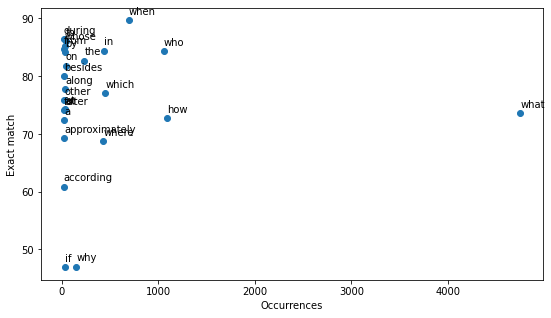

In [85]:
import matplotlib.pyplot as plt

x1 = count
y1 = em_list

plt.figure(figsize=(9,5))

plt.scatter(x1, y1, label = "line 1")
plt.xlabel('Occurrences')
plt.ylabel('Exact match')

for i, q in enumerate(qheads):
    plt.annotate(q, (count[i], em_list[i]),  (count[i], em_list[i] + 1))

# Display a figure.
plt.show()

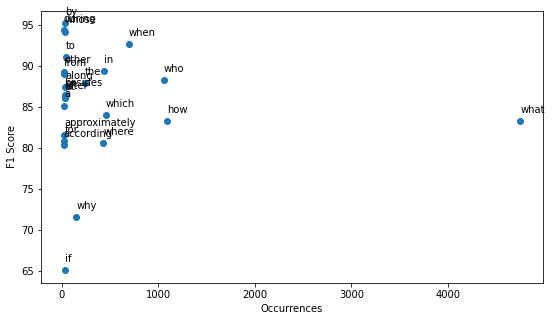

In [86]:
x1 = count
y1 = f1_list

plt.figure(figsize=(9,5))

plt.scatter(x1, y1, label = "line 1")
plt.xlabel('Occurrences')
plt.ylabel('F1 Score')

for i, q in enumerate(qheads):
    plt.annotate(q, (count[i], f1_list[i]),  (count[i], f1_list[i] + 1))

# Display a figure.
plt.show()

In [87]:
def get_char_diff(row: pd.core.series.Series) -> int:
    """Compute the difference, in terms of the number of different charecters
       between the real answer and the predicted one
    """
    return sum(1 for a, b in zip(row["answers.text"], row.prediction_text) if a != b) + abs(len(row["answers.text"]) - len(row.prediction_text))
  
test_dataframe['difference'] = test_dataframe.apply(get_char_diff, axis=1)
test_dataframe

,title,context,question,id,answers.answer_start,answers.text,prediction_text,answers,difference
0,Super_Bowl_50,Super Bowl 50 was an American football game to...,which,56be4db0acb8001400a502ec,"[177, 177, 177]",Denver Broncos,Denver Broncos,"{'answer_start': [177, 177, 177], 'text': ['De...",0
1,Super_Bowl_50,Super Bowl 50 was an American football game to...,which,56be4db0acb8001400a502ed,"[249, 249, 249]",Carolina Panthers,Carolina Panthers,"{'answer_start': [249, 249, 249], 'text': ['Ca...",0
2,Super_Bowl_50,Super Bowl 50 was an American football game to...,where,56be4db0acb8001400a502ee,"[403, 355, 355]","Santa Clara, California",Levi's Stadium,"{'answer_start': [403, 355, 355], 'text': ['Sa...",23
3,Super_Bowl_50,Super Bowl 50 was an American football game to...,which,56be4db0acb8001400a502ef,"[177, 177, 177]",Denver Broncos,Denver Broncos,"{'answer_start': [177, 177, 177], 'text': ['De...",0
4,Super_Bowl_50,Super Bowl 50 was an American football game to...,what,56be4db0acb8001400a502f0,"[488, 488, 521]",gold,gold,"{'answer_start': [488, 488, 521], 'text': ['go...",0
...,...,...,...,...,...,...,...,...,...
10565,Force,"The pound-force has a metric counterpart, less...",what,5737aafd1c456719005744fb,"[82, 4, 82, 82, 78]",kilogram-force,The pound-force,"{'answer_start': [82, 4, 82, 82, 78], 'text': ...",15
10566,Force,"The pound-force has a metric counterpart, less...",what,5737aafd1c456719005744fc,"[114, 114, 114, 114, 114]",kilopond,kilopond,"{'answer_start': [114, 114, 114, 114, 114], 't...",0
10567,Force,"The pound-force has a metric counterpart, less...",what,5737aafd1c456719005744fd,"[274, 267, 267, 267, 263]",slug,the metric slug,"{'answer_start': [274, 267, 267, 267, 263], 't...",15
10568,Force,"The pound-force has a metric counterpart, less...",what,5737aafd1c456719005744fe,"[712, 712, 712, 712, 712]",kip,the metric slug,"{'answer_start': [712, 712, 712, 712, 712], 't...",15


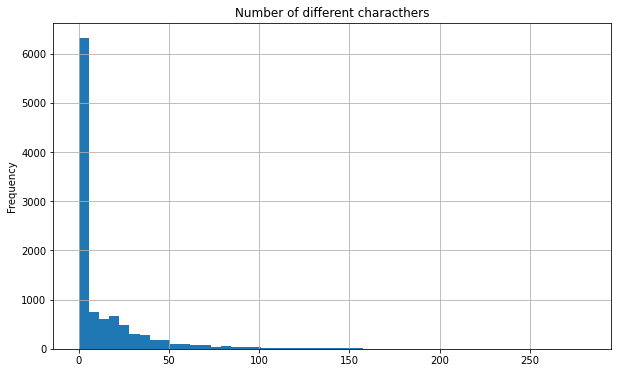

In [88]:
figsize = (10,6)
test_dataframe['difference'].plot.hist(title="Number of different characthers", bins= 50, figsize=figsize, grid=True)

In [89]:
total = test_dataframe['difference'][test_dataframe['difference'] != 0].shape[0]
sorted_series = test_dataframe['difference'][test_dataframe['difference'] != 0].value_counts().sort_values(ascending=False)[0:25]
numbers = list(sorted_series.index)

print("# Diff.Chars\tCount\t\tPercentage\n")
for i, j in enumerate(sorted_series):
  print("{: <15} {: <15} {:.1f}%".format(numbers[i],j,j/total*100))

# Diff.Chars	Count		Percentage

16              145             3.2%
1               140             3.1%
10              136             3.0%
11              134             2.9%
8               132             2.9%
12              129             2.8%
20              122             2.7%
17              122             2.7%
7               121             2.7%
18              121             2.7%
6               117             2.6%
14              114             2.5%
15              114             2.5%
13              114             2.5%
19              111             2.4%
9               107             2.4%
21              104             2.3%
24              100             2.2%
22              93              2.0%
23              91              2.0%
25              88              1.9%
26              74              1.6%
28              65              1.4%
29              65              1.4%
31              64              1.4%


In [90]:
# This function instead of returning the best prediction, returns the best 5 predictions

def postprocess_qa_5predictions(examples: datasets.arrow_dataset.Dataset,
                               features: datasets.arrow_dataset.Dataset,
                               raw_predictions: tuple,
                               n_best_size: int = 20,
                               max_answer_length: int = 50) -> collections.OrderedDict:
    """Function used to select the 5 top answers from the raw predictions

      Args:
        examples: Squad samples
        features: Squad features
        raw_predictions: model predictions
    """
    all_start_logits, all_end_logits = raw_predictions
    # Build a map example to its corresponding features.
    example_id_to_index = {k: i for i, k in enumerate(examples["id"])}
    features_per_example = collections.defaultdict(list)
    for i, feature in enumerate(features):
        features_per_example[example_id_to_index[feature["example_id"]]].append(i)

    # The dictionaries we have to fill.
    predictions = collections.OrderedDict()

    # Let's loop over all the examples!
    for example_index, example in enumerate(tqdm(examples)):
        # Those are the indices of the features associated to the current example.
        feature_indices = features_per_example[example_index]
        valid_answers = []
        
        context = example["context"]
        # Looping through all the features associated to the current example.
        for feature_index in feature_indices:
            # We grab the predictions of the model for this feature.
            start_logits = all_start_logits[feature_index]
            end_logits = all_end_logits[feature_index]
            # This is what will allow us to map some the positions in our logits to span of texts in the original
            # context.
            offset_mapping = features[feature_index]["offset_mapping"]

            # Update minimum null prediction.
            cls_index = features[feature_index]["input_ids"].index(tokenizer.cls_token_id)
            feature_null_score = start_logits[cls_index] + end_logits[cls_index]

            # Go through all possibilities for the `n_best_size` greater start and end logits.
            start_indexes = np.argsort(start_logits)[-1 : -n_best_size - 1 : -1].tolist()
            end_indexes = np.argsort(end_logits)[-1 : -n_best_size - 1 : -1].tolist()
            for start_index in start_indexes:
                for end_index in end_indexes:
                    # Don't consider out-of-scope answers, either because the indices are out of bounds or correspond
                    # to part of the input_ids that are not in the context.
                    if (
                        start_index >= len(offset_mapping)
                        or end_index >= len(offset_mapping)
                        or offset_mapping[start_index] is None
                        or offset_mapping[end_index] is None
                    ):
                        continue
                    # Don't consider answers with a length that is either < 0 or > max_answer_length.
                    if end_index < start_index or end_index - start_index + 1 > max_answer_length:
                        continue

                    start_char = offset_mapping[start_index][0]
                    end_char = offset_mapping[end_index][1]
                    valid_answers.append(
                        {
                            "score": start_logits[start_index] + end_logits[end_index],
                            "text": context[start_char: end_char]
                        }
                    )
        
        if len(valid_answers) > 0:
            best_answer = sorted(valid_answers, key=lambda x: x["score"], reverse=True)[0:5]
        else:
            # In the very rare edge case we have not a single non-null prediction, we create a fake prediction to avoid
            # failure.
            best_answer = [{"text": "", "score": 0.0}]
        
        # Let's pick our final answer
        predictions[example["id"]] = [a_dict["text"] for a_dict in best_answer] 

    return predictions

Now we collect the best 5 predictions for each question to compute the "top 5 EM" 

In [91]:
# The Trainer hides the columns that are not used by the model (here example_id and offset_mapping which we will need for our post-processing), so we set them back
test_features.set_format(type=test_features.format["type"], columns=list(test_features.features.keys()))

# To get the final predictions we can apply our post-processing function to our raw predictions
final_predictions = postprocess_qa_5predictions(test_data['train'], test_features, pred.predictions)

formatted_5predictions = {k : v for k, v in final_predictions.items()}

# Hide again the columns that are not used by the model
test_features.set_format(type=test_features.format["type"], columns=['attention_mask', 'end_positions', 'input_ids', 'start_positions'])

100%|██████████| 10570/10570 [00:24<00:00, 438.76it/s]


In [92]:
count = 0
for id in test_dataframe['id']:
  if test_dataframe['answers.text'][test_dataframe.id == id].values[0] in formatted_5predictions[id]:
    count += 1
    
final_predictions = test_dataframe[['id','prediction_text']].to_dict('records')
references = test_dataframe[['answers','id']].to_dict('records')

print("Top 1 exact match and F1 score: {}".format(metric.compute(predictions=final_predictions, references=references)))
print("Top 5 exact match: {}".format(count/len(test_dataframe)))

Top 1 exact match and F1 score: {'exact_match': 75.81835383159887, 'f1': 84.47989708232564}
Top 5 exact match: 0.8222327341532639
